In [111]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

PREFIX='a video of '

In [112]:
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
        "a person riding a bicycle",
        "a certain number of persons fighting",
        "a group of persons playing",
        "a person running",
        "a person lying in the floor",
        "a person chasing other person",
        "a person jumping",
        "a person falling",
        "a person guiding other person",
        "a person stealing other person",
        "a person throwing trash in the floor",
        "a person tripping",
        "a person stealing other person's pocket",
    ]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}

In [113]:
def check_class(description, prompt, list_events):
    if prompt== '':
        #return None
        return PREFIX+normal_prompt
    try:
        return list_events[int(prompt)-1]
    except:
        print(prompt, '\n')
        return None
def check_precision(frames_number, video_name, predicted_events, event, anomaly_classes, prompts, mode):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    all_classes = anomaly_classes
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[video_name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    #prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    # Save frames_number, predicted_events, and prompts into a numpy array)
    wrong=0
    for i in range(len(prompts)):
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        true_class = event if is_anomaly == 1 else normal_class
        #pred_class = predicted_events[i]
        pred_class= check_class(anomaly_classes, prompts[i], predicted_events[i])
        # Get ground truth
        #print(pred_class)
        if pred_class is not None:
            pass
        else:
            wrong += 1
            continue
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    return tp, fp, fn, tn, cm, wrong

rute_stored='/home/ubuntu/Tesis/Storage/M4MulticlassALLDescriptions'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
all_prompts = []
all_description = []
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
prompts_number=0
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
contador=0
for file in files:
    #print(file)
    name= file.split('_CLIP_')[0]
    mode=file.split('_CLIP_')[1][0]
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    predicted_events=info_stored[1]
    #print(predicted_events)
    prompts=info_stored[2]
    all_prompts += list(prompts)
    all_description+= list(predicted_events)
    prompts_number += len(prompts)
    tp, fp, fn, tn, cm , not_used= check_precision(frames_number, name, predicted_events, event, description, prompts, mode)
    contador += not_used  # Update contador based on the sum of the confusion matrix
    cm_sum += cm
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
# Sort the dataframe by the order of the list in the 'Event' column
event_order = description  # Use the 'description' list for sorting order
df['Event'] = pd.Categorical(df['Event'], categories=event_order, ordered=True)
df.sort_values('Event', inplace=True)
print(df)
print(cm_sum.sum(), len(all_prompts), contador)

the video appears to show a normal view of a pedestrian walkway with a person walking on the right side of the image 

the video appears to be a normal view of a person walking on a paved pathway 

the video appears to show a normal view of a pedestrian walkway with several people walking or standing 

the video appears to show a person riding a bicycle 

the video appears to be a normal view of a person walking on a paved area 

the selected description is: 2 

the selected description is: 2 

the video appears to show a normal view of a person walking on a paved path or sidewalk 

the selected description is: 3 

the video appears to show a person walking on a paved area, possibly a campus or a park 

the image shows a wide, empty road with a pedestrian crosswalk and a tree-lined sidewalk 

the image shows a wide, empty road with a pedestrian crosswalk and a tree-lined sidewalk 

the video appears to be a normal view of a person walking on a paved path 

the video appears to show a p

In [114]:
true_positives=df.loc[df['TP'] > 0]
print(f"Total true positives: {len(true_positives)} out of {len(df)} ({len(true_positives)/len(df)*100:.2f}%)")
print(true_positives.shape, df.shape)
no_true_positives=df.loc[df['TP'] ==0]
print(no_true_positives)

Total true positives: 132 out of 252 (52.38%)
(132, 7) (252, 7)
        Name                                              Event Mode TP FP  \
106  D043_01    a video of a certain number of persons fighting    3  0  0   
120   000327              a video of a group of persons playing    3  0  0   
125   000334              a video of a group of persons playing    3  0  0   
14    000314              a video of a group of persons playing    3  0  0   
179   000258              a video of a group of persons playing    3  0  0   
..       ...                                                ...  ... .. ..   
214  4_086_1  a video of a person stealing other person's po...    3  0  0   
182  D149_03  a video of a person stealing other person's po...    3  0  0   
10   D158_13  a video of a person stealing other person's po...    3  0  0   
8    D148_04  a video of a person stealing other person's po...    3  0  0   
90   D149_07  a video of a person stealing other person's po...    3  0  0   


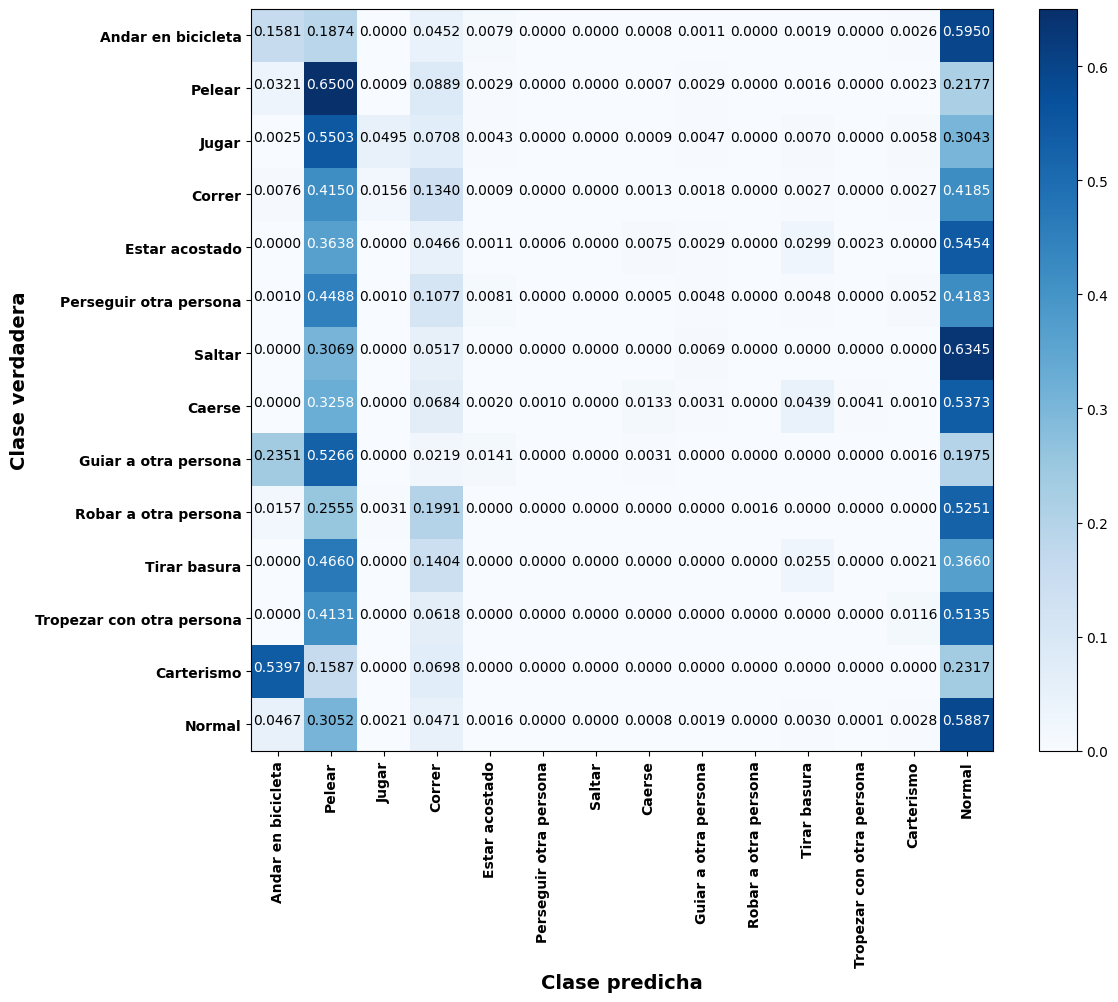

In [115]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
#plt.savefig(f"CM/confusion_matrix_{mode_names[mode]}.png", bbox_inches='tight')
plt.show()

In [116]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                              Event Mode  TP FP  \
215  1_067_1               a video of a person riding a bicycle    3  21  0   
202   000253               a video of a person riding a bicycle    3   3  0   
89   4_077_1               a video of a person riding a bicycle    3  14  0   
199  D013_02               a video of a person riding a bicycle    3  54  1   
78    000289               a video of a person riding a bicycle    3  25  0   
..       ...                                                ...  ...  .. ..   
214  4_086_1  a video of a person stealing other person's po...    3   0  0   
182  D149_03  a video of a person stealing other person's po...    3   0  0   
10   D158_13  a video of a person stealing other person's po...    3   0  0   
8    D148_04  a video of a person stealing other person's po...    3   0  0   
90   D149_07  a video of a person stealing other person's po...    3   0  0   

      FN   TN  
215    3   29  
202   56   80  
89 

/tmp/ipykernel_8457/2034563803.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sum = df_respaldo.groupby(["Event", "Mode"])[
/tmp/ipykernel_8457/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.997624703087886 0.6684491978609626 0.9201101928374655 0.581081081081081
 1.0 1.0 1.0 0.8]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_8457/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.1580730146782085 0.6500113045444269 0.04945217648800711
 0.1340160284951024 0.0011494252873563218 0.0 0.0 0.0132788

In [117]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values)

           AP
Mode         
3     0.21369


/tmp/ipykernel_8457/3489928985.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0 1.0 1.0 0.9818181818181818 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8586956521739131 0.4888888888888889
 1.0 0.9259259259259259 0.4864864864864865 0.8956521739130435
 0.4050632911392405 1.0 0.6544117647058824 0.4269005847953216
 0.8333333333333334 0.2926829268292683 0.5526315789473685
 0.6518518518518519 1.0 0.6304347826086957 0.6666666666666666
 0.2268041237113402 0.6666666666666666 0.14444444444444443
 0.6931818181818182 0.6818181818181818 0.3300970873786408
 0.7142857142857143 0.8620689655172413 0.8846153846153846
 0.7196969696969697 0.8625429553264605 1.0 0.5639097744360902
 0.5511363636363636 0.9824561403508771 0.6920731707317073
 0.5217391304347826 0.8620689655172413 0.7448979591836735 1.0 0.8125 1.0
 0.2361111111111111 1.0 1.0 0.8076923076923077 1.0 1.0 1.0 1.0 1.0 1.0
 0.

In [118]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingDevM4MC_ALLDescriptions.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
print(df_fps)
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

14.482931556304296 hours


            Name  Mode  True Positive  False Positive  False Negative  \
0    4_076_1.mp4     3              0               0               0   
1    3_106_1.mp4     3              0               0               0   
2    1_067_1.mp4     3              0               0               0   
3    1_066_1.mp4     3              0               0               0   
4    2_096_1.mp4     3              0               0               0   
..           ...   ...            ...             ...             ...   
247  D148_04.avi     3              0               0               0   
248  D149_05.avi     3              0               0               0   
249  D158_13.avi     3              0               0               0   
250  D149_07.avi     3              0               0               0   
251  D149_03.avi     3              0               0               0   

     True Negative                                         True Event  \
0                0     